In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
traffic_data = pd.read_csv('filtered_normalised_traffic_data.csv')
traffic_data

,datetime,grid_id,estimated_traffic
0,2008-02-02 13:30:00,10_10,65
1,2008-02-02 13:30:00,10_2,130
2,2008-02-02 13:30:00,10_3,325
3,2008-02-02 13:30:00,10_4,130
4,2008-02-02 13:30:00,10_5,65
...,...,...,...
59195,2008-02-08 17:30:00,3_1,390
59196,2008-02-08 17:30:00,4_1,455
59197,2008-02-08 17:30:00,1_4,520
59198,2008-02-08 17:30:00,3_9,130


### Forecasting baseline

In [3]:
# 1. Create Lag Features
for lag in range(1, 6):
    traffic_data[f'l{lag}'] = traffic_data.groupby('grid_id')['estimated_traffic'].shift(lag)

# 2. Create Time Features
traffic_data['datetime'] = pd.to_datetime(traffic_data['datetime'])
traffic_data['hour'] = traffic_data['datetime'].dt.hour
traffic_data['day_of_week'] = traffic_data['datetime'].dt.dayofweek
traffic_data['is_weekend'] = traffic_data['day_of_week'].isin([5, 6]).astype(int)
traffic_data['quarter'] = traffic_data['datetime'].dt.quarter
traffic_data['day_of_month'] = traffic_data['datetime'].dt.day
traffic_data['week_of_year'] = traffic_data['datetime'].dt.isocalendar().week

# 3. Handle Missing Values
traffic_data = traffic_data.dropna(subset=[f'l{i}' for i in range(1, 6)])

# 4. Train/Val/Test Split
traffic_data = traffic_data.sort_values('datetime')
n_total = len(traffic_data)
train = traffic_data.iloc[:int(n_total * 0.8)]
val = traffic_data.iloc[int(n_total * 0.8):int(n_total * 0.9)]
test = traffic_data.iloc[int(n_total * 0.9):]

# 5. Prepare Features and Target
features = ['grid_id', 'hour', 'day_of_week', 'is_weekend', 
            'quarter', 'day_of_month', 'week_of_year'] + [f'l{i}' for i in range(1, 6)]
target = 'estimated_traffic'

X_train, y_train = train[features], train[target]
X_val, y_val = val[features], val[target]
X_test, y_test = test[features], test[target]

# 6. Train Model
model = CatBoostRegressor(
    cat_features=['grid_id'],
    random_seed=42,
    verbose=0
)
model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=50, early_stopping_rounds=100)

Learning rate set to 0.093187
0:	learn: 14667.5923346	test: 8912.4085573	best: 8912.4085573 (0)	total: 68.3ms	remaining: 1m 8s
50:	learn: 970.6259047	test: 858.9280466	best: 858.9280466 (50)	total: 676ms	remaining: 12.6s
100:	learn: 815.3261455	test: 830.8862019	best: 830.8452392 (99)	total: 1.25s	remaining: 11.1s
150:	learn: 729.1169585	test: 817.4231903	best: 817.4231903 (150)	total: 1.81s	remaining: 10.2s
200:	learn: 668.0587602	test: 800.2533464	best: 800.0519612 (199)	total: 2.38s	remaining: 9.44s
250:	learn: 626.0769445	test: 787.2366065	best: 786.4447209 (248)	total: 2.93s	remaining: 8.74s
300:	learn: 597.8321865	test: 780.4425467	best: 780.4269785 (299)	total: 3.47s	remaining: 8.05s
350:	learn: 572.4643508	test: 769.2669220	best: 769.1272930 (349)	total: 4.06s	remaining: 7.51s
400:	learn: 552.4564183	test: 768.2554712	best: 767.9318947 (372)	total: 4.62s	remaining: 6.91s
450:	learn: 538.2216671	test: 763.3487956	best: 763.3487956 (450)	total: 5.14s	remaining: 6.26s
500:	learn: 

Test Set Performance:
MAE: 223.24


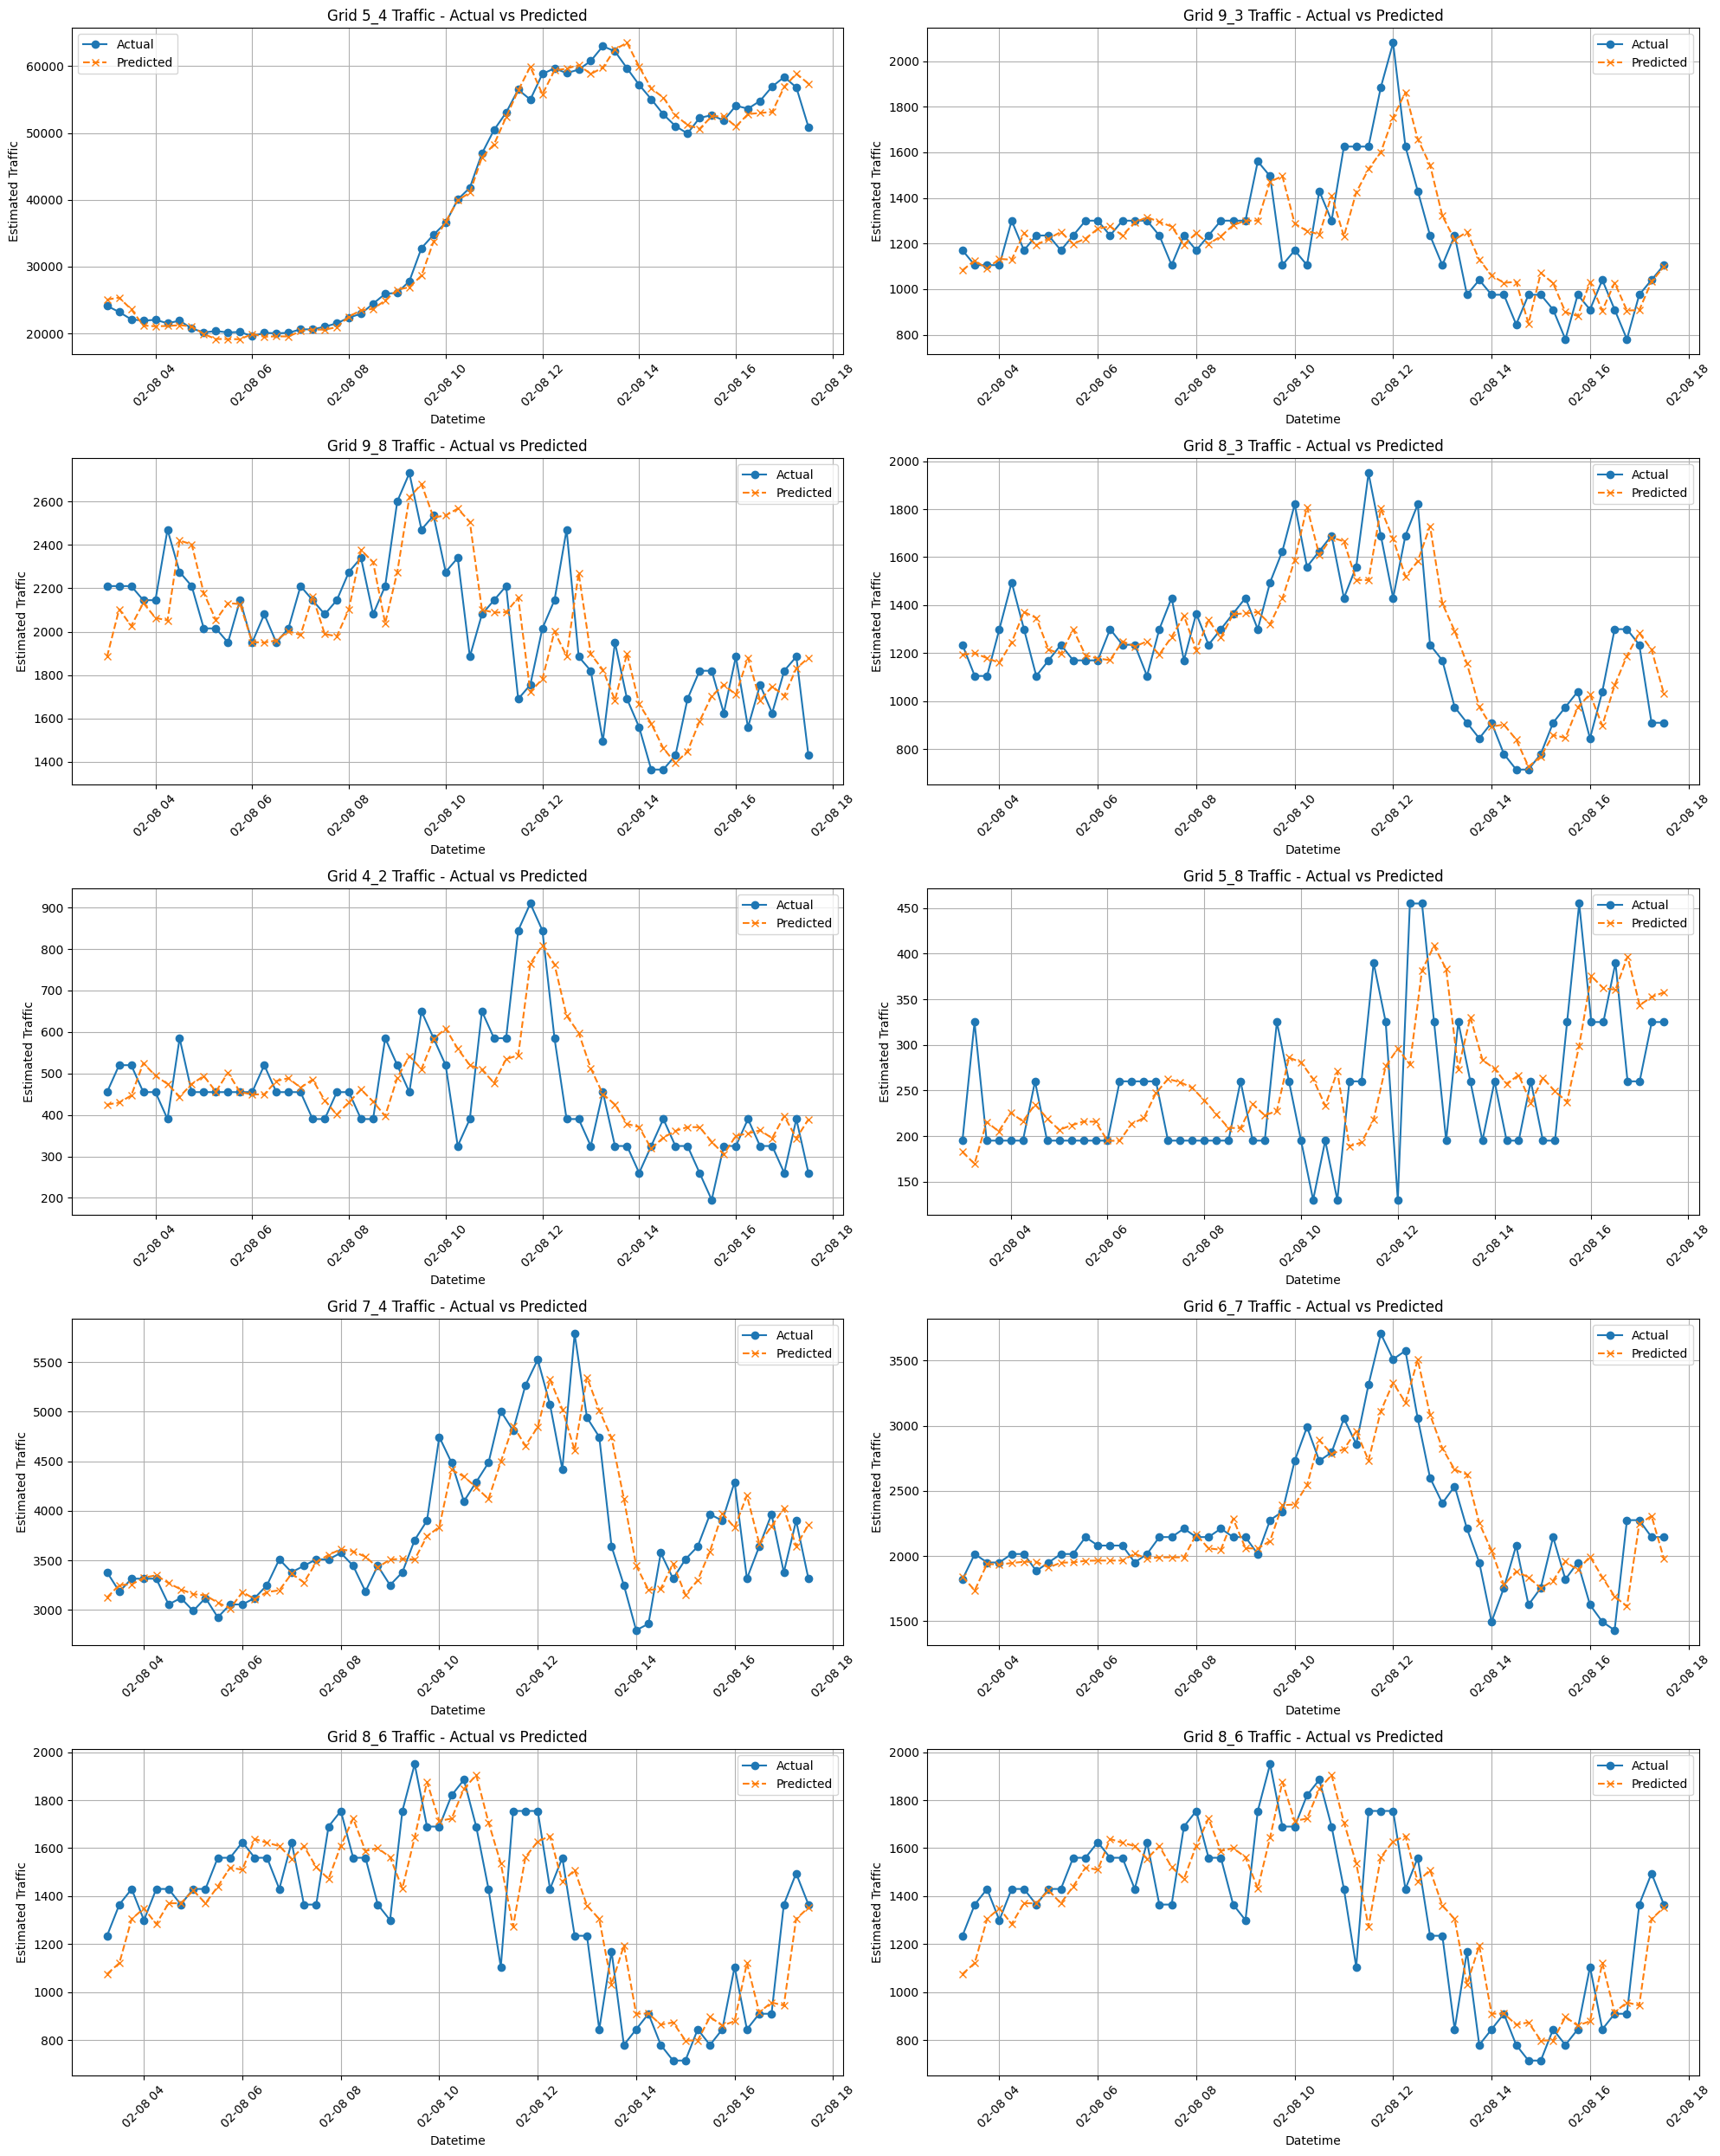

In [4]:
# Generate predictions on test set
y_pred = model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)

print(f"Test Set Performance:")
print(f"MAE: {mae:.2f}")

# Create results dataframe
test_results = test[['datetime', 'grid_id', 'estimated_traffic']].copy()
test_results['predicted'] = y_pred

# Plot random 10 grids
np.random.seed(42)
selected_grids = np.random.choice(test_results['grid_id'].unique(), 10)

plt.figure(figsize=(20, 25))
for i, grid_id in enumerate(selected_grids, 1):
    grid_data = test_results[test_results['grid_id'] == grid_id]
    
    plt.subplot(5, 2, i)
    plt.plot(grid_data['datetime'], grid_data['estimated_traffic'], label='Actual', marker='o')
    plt.plot(grid_data['datetime'], grid_data['predicted'], label='Predicted', linestyle='--', marker='x')
    plt.title(f'Grid {grid_id} Traffic - Actual vs Predicted')
    plt.xlabel('Datetime')
    plt.ylabel('Estimated Traffic')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

TODO: we see that scales of different time series are different, hence, we need to normalise either the data or the count of the metrics so that they will be relevant

In [21]:
# 7. Forecasting Function
def forecast(grid_id, test_set, model, n_forecast, plot=False):
    """
    Auto-regressive forecasting function
    Args:
        grid_id: Target grid to forecast
        test_set: Test dataset containing historical data
        model: Trained CatBoost model
        n_forecast: Number of steps to forecast (15-min intervals)
    
    Returns:
        forecast_dates: List of datetime objects
        predictions: Forecasted values
    """
    grid_data = test_set[test_set['grid_id'] == grid_id].copy()
    
    if len(grid_data) < 5:
        raise ValueError("Insufficient historical data for forecasting")
    
    # Initialize with last 5 values from test set
    last_sequence = grid_data['estimated_traffic'].values[-5:].tolist()
    last_date = grid_data['datetime'].max()
    
    forecast_dates = [last_date + pd.Timedelta(minutes=15*(i+1)) for i in range(n_forecast)]
    predictions = []
    current_lags = last_sequence.copy()
    
    for i in range(n_forecast):
        current_date = forecast_dates[i]
        
        # Create time features
        time_features = {
            'hour': current_date.hour,
            'day_of_week': current_date.dayofweek,
            'is_weekend': int(current_date.dayofweek in [5, 6]),
            'quarter': current_date.quarter,
            'day_of_month': current_date.day,
            'week_of_year': current_date.isocalendar().week,
        }
        
        # Create lag features
        lag_features = {f'l{j+1}': current_lags[-(j+1)] for j in range(5)}
        
        # Create feature vector
        features = {
            'grid_id': grid_id,
            **time_features,
            **lag_features
        }
        
        # Predict
        features_df = pd.DataFrame([features])
        pred = model.predict(features_df)[0]
        predictions.append(pred)
        
        # Update lags
        current_lags.append(pred)
        current_lags = current_lags[-5:]  # Maintain window of 5 lags

        # Plotting functionality
    if plot:
        plt.figure(figsize=(12, 6))
        
        # Get last 10 historical values
        history = grid_data.tail(10)[['datetime', 'estimated_traffic']]
        
        # Create prediction dataframe
        forecast_df = pd.DataFrame({
            'datetime': forecast_dates,
            'predicted': predictions
        })
        
        # Plot historical values
        plt.plot(history['datetime'], history['estimated_traffic'], 
                'bo-', label='Historical Traffic', markersize=8)
        
        # Plot predictions
        plt.plot(forecast_df['datetime'], forecast_df['predicted'], 
                'rx--', label='Forecasted Traffic', markersize=8)
        
        # Add vertical line at forecast start
        plt.axvline(x=last_date, color='k', linestyle='--', label='Forecast Start')
        
        plt.title(f'Traffic Forecast for Grid {grid_id}')
        plt.xlabel('Datetime')
        plt.ylabel('Estimated Traffic')
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    return forecast_dates, predictions

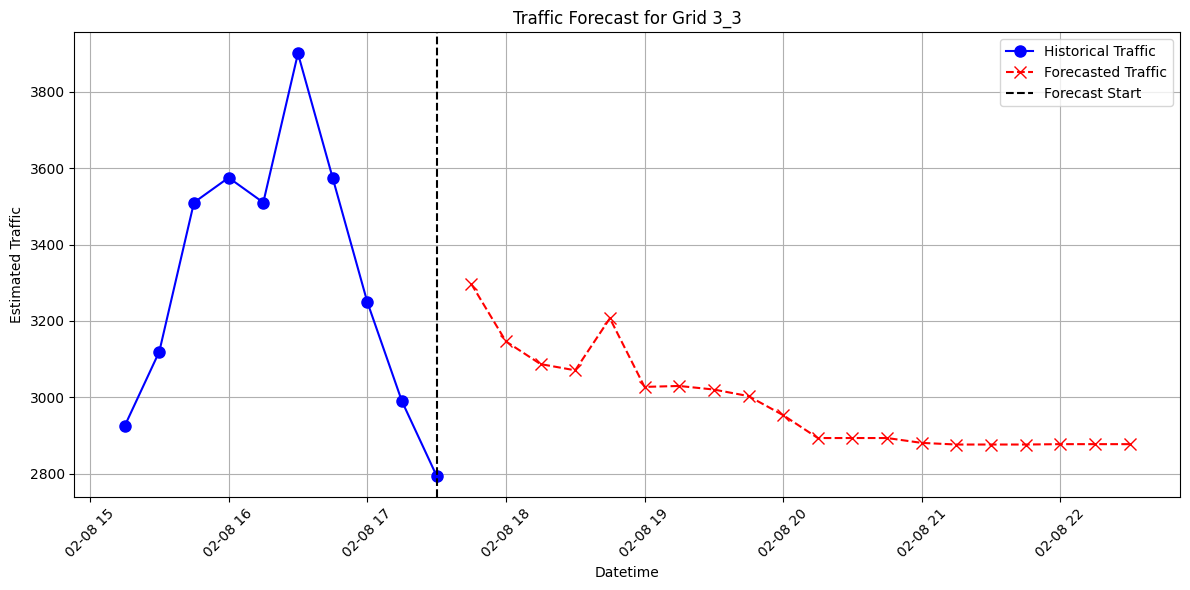

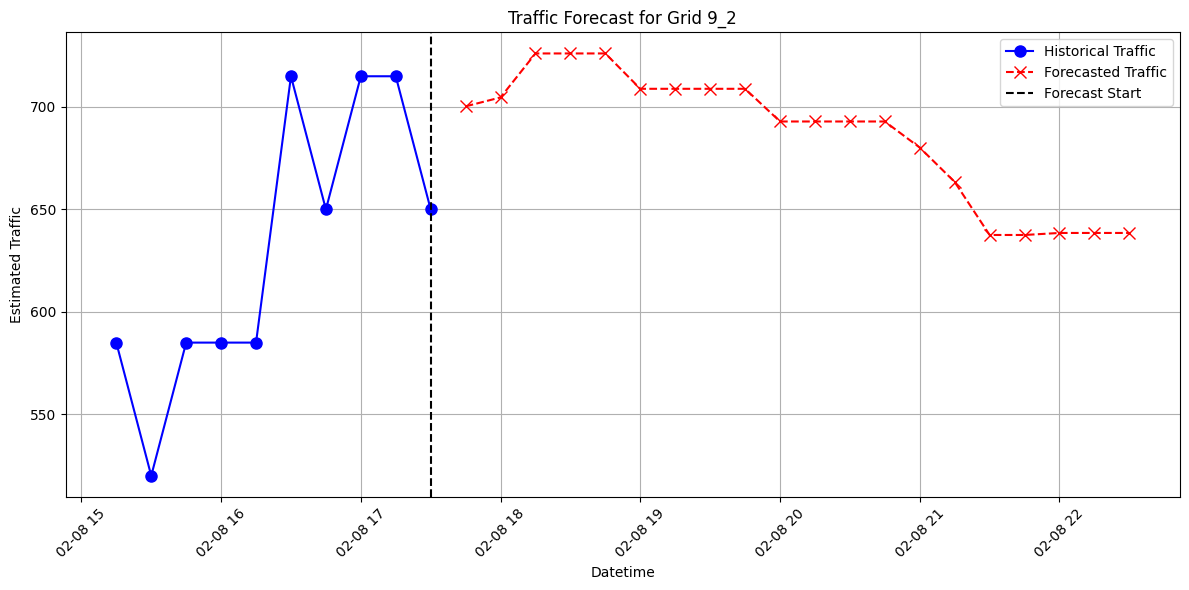

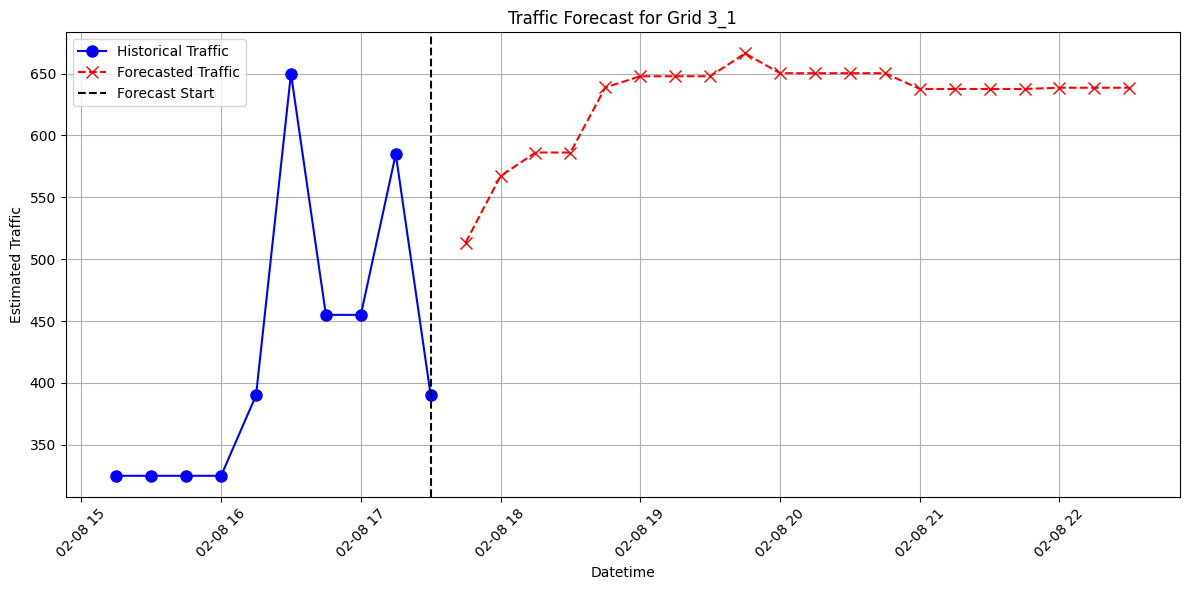

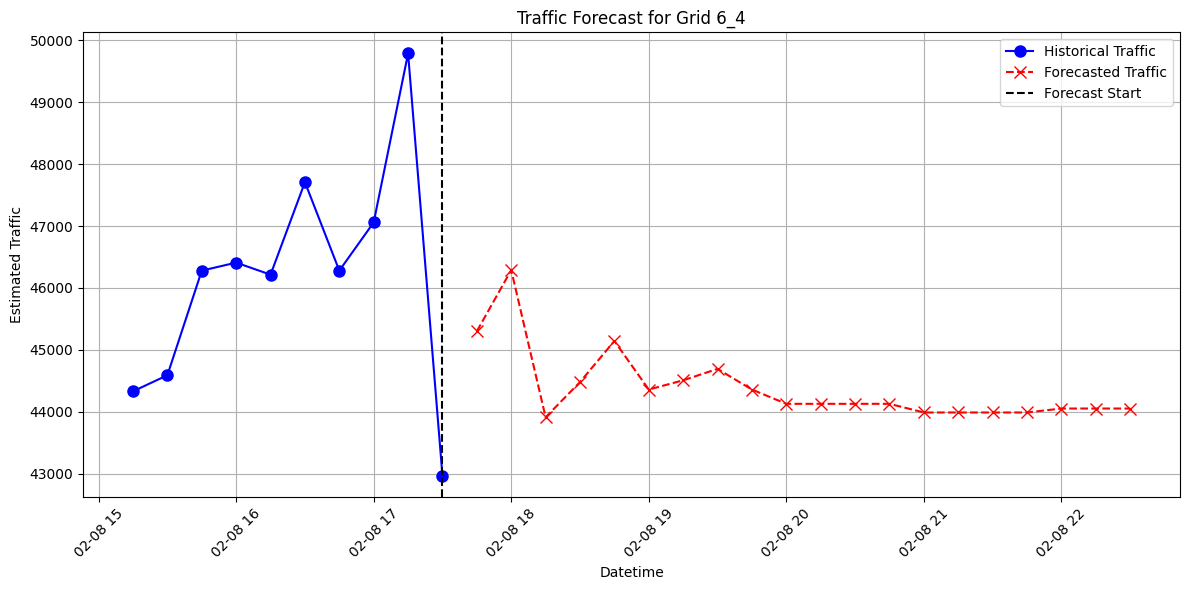

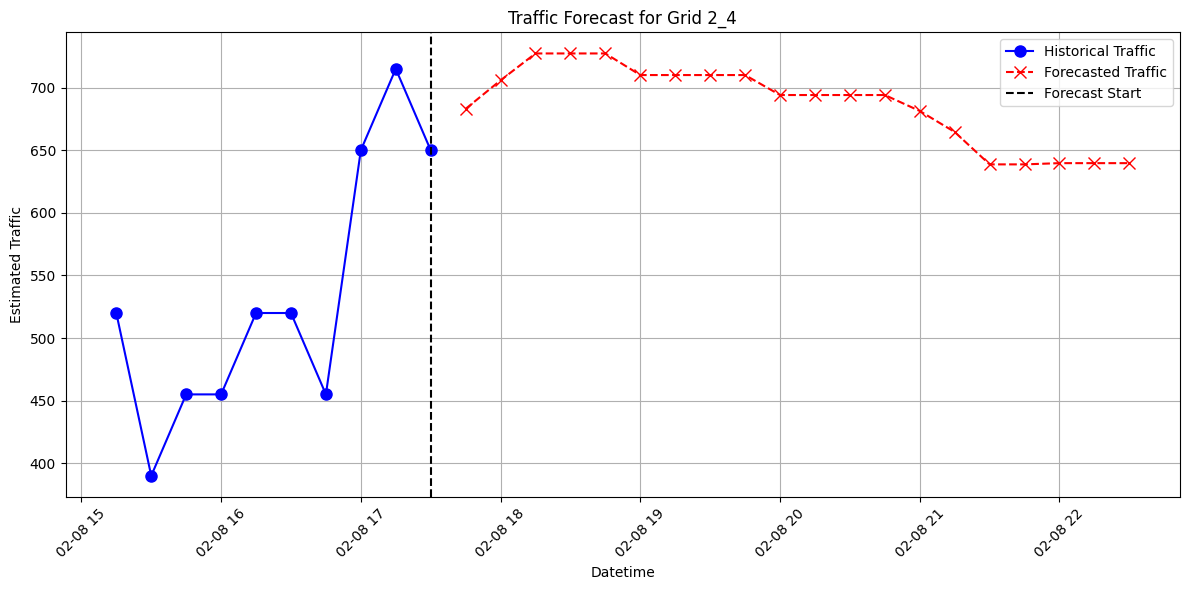

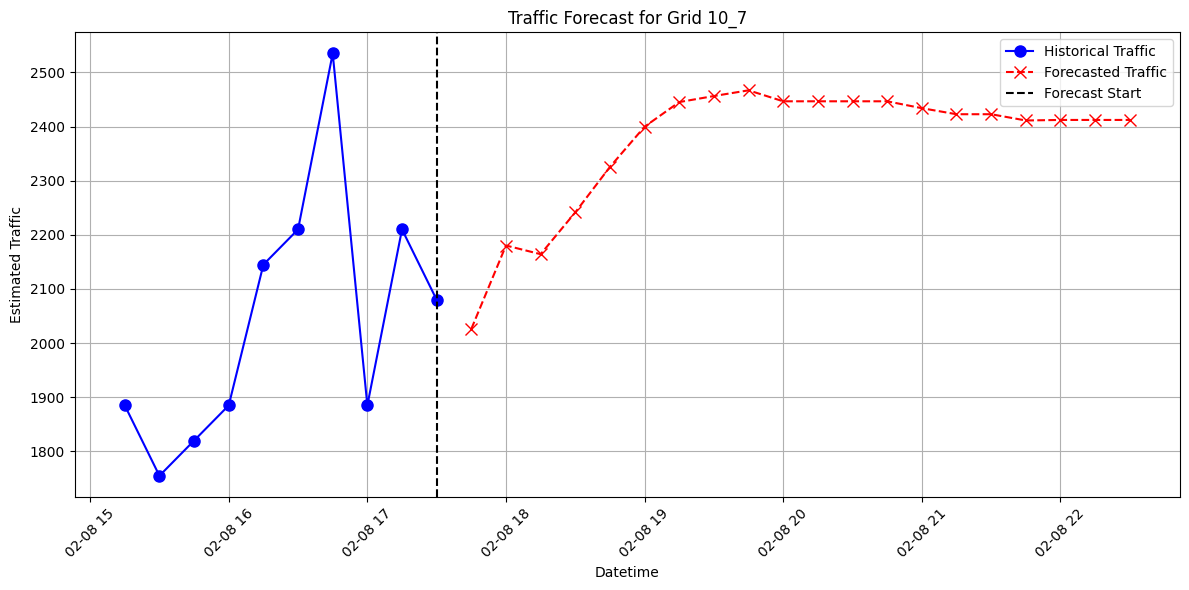

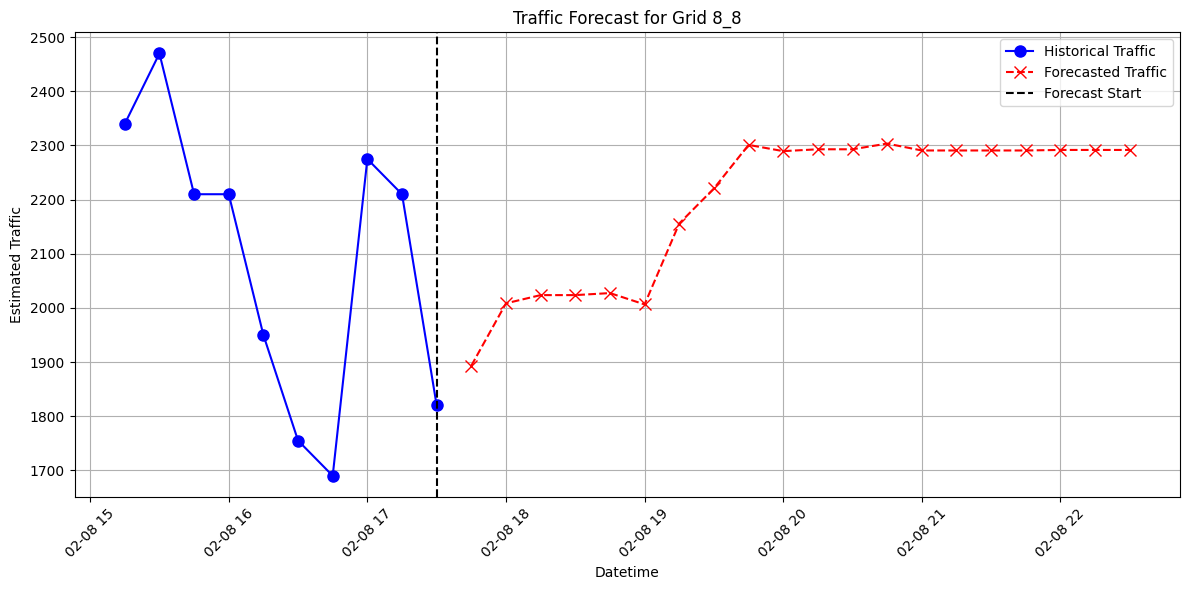

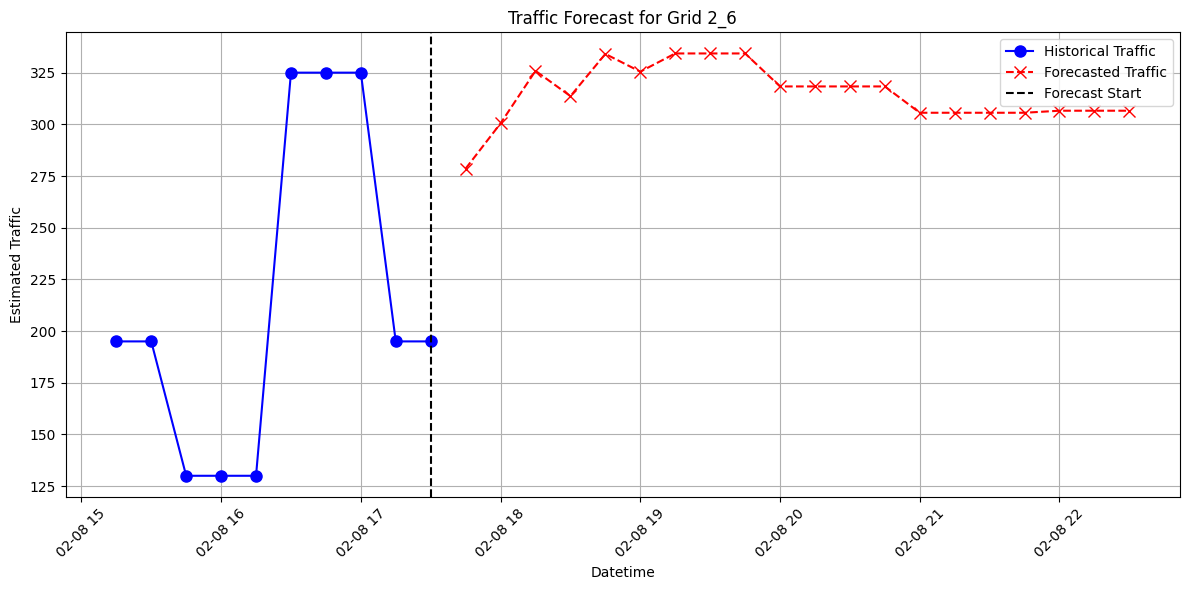

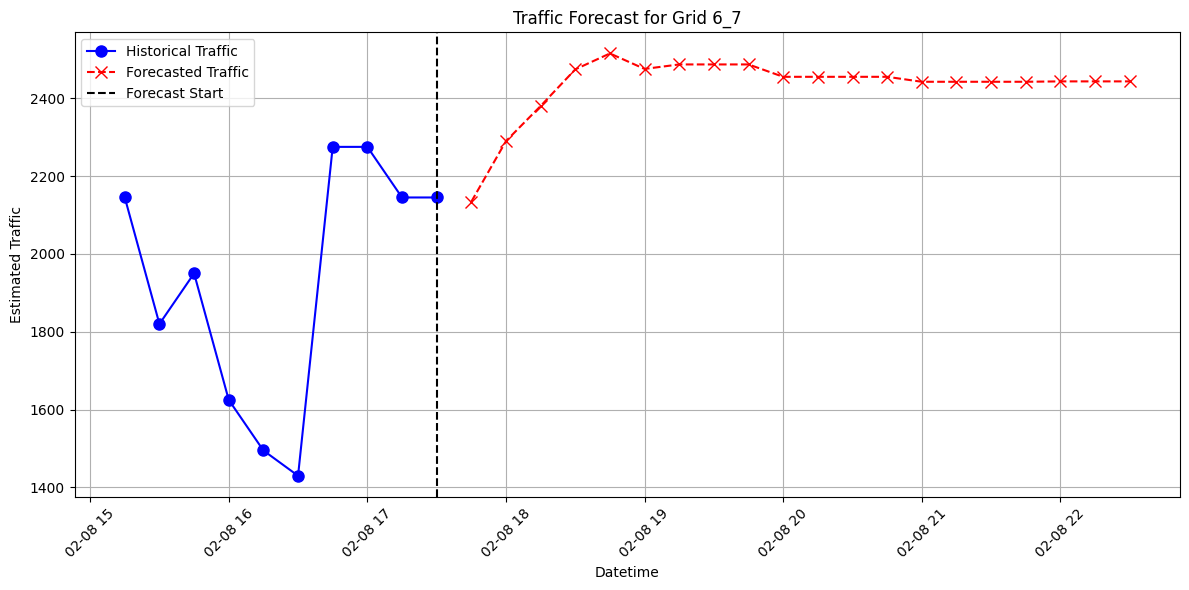

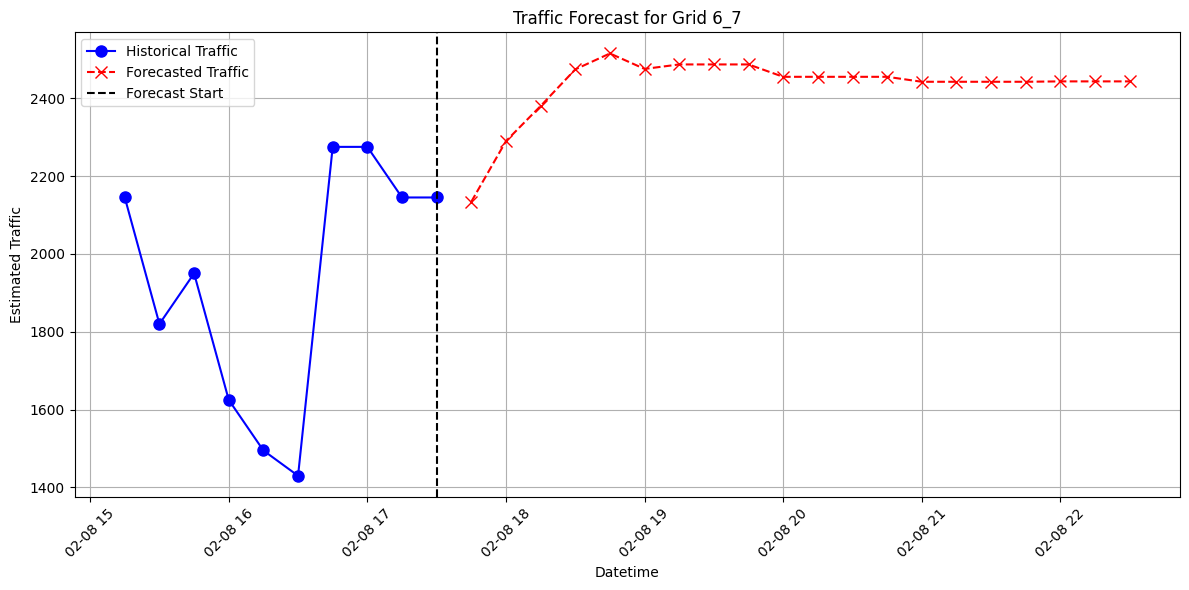

In [26]:
for grid in selected_grids:
    forecast_dates, predictions = forecast(grid, test_results, model, n_forecast=20, plot=True)

**We see that the forecast values converge to a particular point pretty fast, but:**

+ We do not need to forecast for many periods, just 3-4 is probably okay

+ This is just a baseline, a better model will be made soon

+ In addition, we will probably add more features

### Anomaly detection baseline

**We will start with a very simple approach - outlier detection:**

+ For every grid_id, we will calculate the running mean and standard deviation of the estimated traffic values. Then, we will flag any value that is more than 2 standard deviations away from the mean as an anomaly

+ Later we can try using Isolation Forest, which detects outliers in a different way

+ We also can detect changes in the mean and volatility in the sliding windows using the special libraries

+ After that, we can try more sophisticated approaches

+ But for now the simple baseline will work

In [5]:
import pickle
from collections import defaultdict

In [6]:
def calculate_anomalies(data, grid_stats=None, update_stats=True, return_stats=False):
    """
    Calculate anomalies with continuous statistics updating by default
    Args:
        data: DataFrame containing traffic data
        grid_stats: Pre-trained statistics (None for training mode)
        update_stats: Whether to update statistics with new data (default True)
        return_stats: Whether to return updated statistics
    """
    data = data.copy().sort_values('datetime')
    data['anomaly'] = False
    data['running_mean'] = np.nan
    data['running_std'] = np.nan

    # Initialize statistics storage
    if grid_stats is None:
        # Training mode - always update statistics
        grid_stats = defaultdict(lambda: {'n': 0, 'mean': 0.0, 'M2': 0.0, 'std': 0.0})
        update_stats = True  # Force update in training mode
    else:
        # Convert to defaultdict for handling new grids
        grid_stats = defaultdict(lambda: {'n': 0, 'mean': 0.0, 'M2': 0.0, 'std': 0.0}, 
                                grid_stats)

    for idx, row in data.iterrows():
        grid_id = row['grid_id']
        value = row['estimated_traffic']
        stats = grid_stats[grid_id]

        # Check anomaly condition
        if stats['n'] >= 2:
            lower_bound = stats['mean'] - 2 * stats['std']
            upper_bound = stats['mean'] + 2 * stats['std']
            if not (lower_bound <= value <= upper_bound):
                data.at[idx, 'anomaly'] = True

        # Update statistics if enabled
        if update_stats:
            # Welford's online algorithm
            stats['n'] += 1
            delta = value - stats['mean']
            stats['mean'] += delta / stats['n']
            delta2 = value - stats['mean']
            stats['M2'] += delta * delta2
            
            # Calculate standard deviation
            stats['std'] = np.sqrt(stats['M2'] / stats['n']) if stats['n'] >= 2 else 0.0

        # Store current statistics
        data.at[idx, 'running_mean'] = stats['mean']
        data.at[idx, 'running_std'] = stats['std']

    if return_stats:
        return data, dict(grid_stats)
    return data

# Training pipeline
def train_anomaly_detector(full_data, train_ratio=0.9, save_path='grid_stats.pkl'):
    """Train and save initial statistics"""
    train_data = full_data.iloc[:int(len(full_data)*train_ratio)]
    test_data = full_data.iloc[int(len(full_data)*train_ratio):]
    
    # Train with statistics calculation
    train_result, grid_stats = calculate_anomalies(train_data, return_stats=True)
    
    # Save initial statistics
    with open(save_path, 'wb') as f:
        pickle.dump(grid_stats, f)
    
    return train_result, test_data

# Inference pipeline
def run_anomaly_inference(new_data, update_stats=True, stats_path='grid_stats.pkl'):
    """Run inference with optional statistics updating"""
    # Load current statistics
    with open(stats_path, 'rb') as f:
        grid_stats = pickle.load(f)
    
    # Process new data
    result, new_stats = calculate_anomalies(new_data, grid_stats=grid_stats, 
                                          update_stats=update_stats, return_stats=True)
    
    # Update stored statistics if requested
    if update_stats:
        with open(stats_path, 'wb') as f:
            pickle.dump(new_stats, f)
    
    return result

In [7]:
# Example usage -------------------------------------------------

# 1. Train on historical data
train_data, test_data = train_anomaly_detector(traffic_data)

# 2. Run inference on test data (updating statistics by default)
test_results = run_anomaly_inference(test_data)

# 3. View results
print("Training anomalies:", train_data['anomaly'].sum())
print("Test anomalies:", test_results['anomaly'].sum())

Training anomalies: 6981
Test anomalies: 691


In [8]:
train_data

,datetime,grid_id,estimated_traffic,l1,l2,l3,l4,l5,hour,day_of_week,is_weekend,quarter,day_of_month,week_of_year,anomaly,running_mean,running_std
500,2008-02-02 14:45:00,10_10,65,65.0,65.0,0.0,0.0,65.0,14,5,1,1,2,5,False,65.000000,0.000000
501,2008-02-02 14:45:00,10_2,130,130.0,130.0,130.0,130.0,130.0,14,5,1,1,2,5,False,130.000000,0.000000
502,2008-02-02 14:45:00,10_3,195,195.0,260.0,195.0,260.0,325.0,14,5,1,1,2,5,False,195.000000,0.000000
503,2008-02-02 14:45:00,10_4,130,195.0,130.0,195.0,130.0,130.0,14,5,1,1,2,5,False,130.000000,0.000000
504,2008-02-02 14:45:00,10_5,0,0.0,0.0,65.0,65.0,65.0,14,5,1,1,2,5,False,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53366,2008-02-08 03:00:00,8_3,1300,1300.0,1040.0,390.0,1300.0,1300.0,3,4,0,1,8,6,False,912.703214,384.691427
53365,2008-02-08 03:00:00,8_2,1430,1365.0,1430.0,520.0,1300.0,1170.0,3,4,0,1,8,6,False,851.143667,399.321928
53396,2008-02-08 03:00:00,4_1,390,390.0,325.0,130.0,390.0,390.0,3,4,0,1,8,6,False,246.975425,151.314722
53359,2008-02-08 03:00:00,7_3,3185,3250.0,2860.0,1105.0,3445.0,3380.0,3,4,0,1,8,6,False,2916.767486,518.450364


In [9]:
test_data

,datetime,grid_id,estimated_traffic,l1,l2,l3,l4,l5,hour,day_of_week,is_weekend,quarter,day_of_month,week_of_year
53394,2008-02-08 03:00:00,13_10,390,390.0,390.0,260.0,390.0,390.0,3,4,0,1,8,6
53393,2008-02-08 03:00:00,12_10,325,325.0,325.0,130.0,325.0,325.0,3,4,0,1,8,6
53392,2008-02-08 03:00:00,7_9,390,325.0,390.0,195.0,325.0,325.0,3,4,0,1,8,6
53391,2008-02-08 03:00:00,13_9,520,585.0,520.0,130.0,650.0,650.0,3,4,0,1,8,6
53390,2008-02-08 03:00:00,9_10,1105,1170.0,780.0,0.0,1105.0,1105.0,3,4,0,1,8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59127,2008-02-08 17:30:00,3_2,1430,1560.0,1560.0,1300.0,1365.0,1560.0,17,4,0,1,8,6
59126,2008-02-08 17:30:00,2_9,130,130.0,195.0,130.0,260.0,65.0,17,4,0,1,8,6
59125,2008-02-08 17:30:00,2_5,1300,1560.0,1690.0,1755.0,1755.0,1690.0,17,4,0,1,8,6
59135,2008-02-08 17:30:00,4_3,1690,1625.0,1495.0,1495.0,1430.0,1365.0,17,4,0,1,8,6


In [10]:
train_data.loc[train_data['anomaly'] == True].grid_id.value_counts()

grid_id
1_10    212
11_8    207
13_7    203
12_7    197
13_8    195
       ... 
3_4      19
4_8      17
9_6      15
5_7      15
8_7      14
Name: count, Length: 100, dtype: int64

### Plot anomalies in case of 1_10

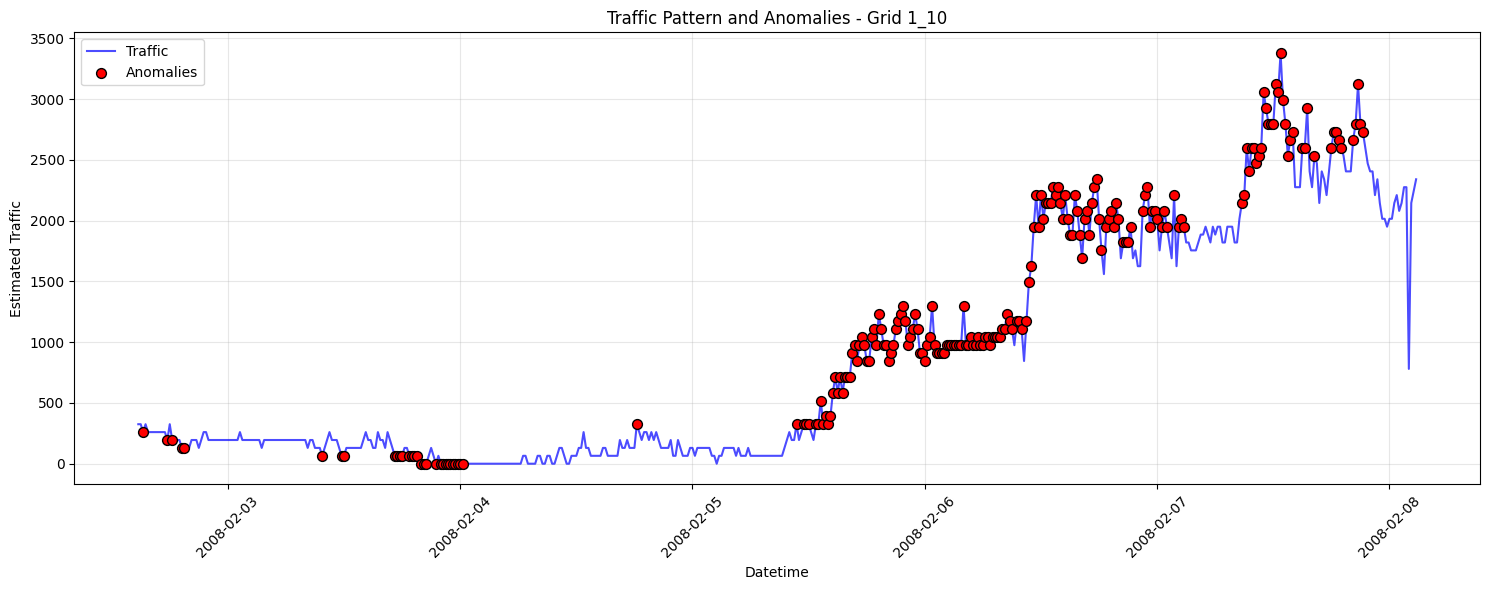

In [11]:
def plot_grid_anomalies(dataset, grid_id, figsize=(15, 6)):
    """
    Plot time series with anomalies highlighted for a specific grid
    
    Args:
        dataset: DataFrame with datetime, estimated_traffic, and anomaly columns
        grid_id: ID of the grid to visualize
        figsize: Figure size (width, height)
    """
    # Filter data for specific grid
    grid_data = dataset[dataset['grid_id'] == grid_id].sort_values('datetime')
    
    if grid_data.empty:
        print(f"No data found for grid {grid_id}")
        return

    # Create plot
    plt.figure(figsize=figsize)
    
    # Plot full time series
    plt.plot(grid_data['datetime'], grid_data['estimated_traffic'], 
             'b-', label='Traffic', alpha=0.7)
    
    # Highlight anomalies
    anomalies = grid_data[grid_data['anomaly']]
    if not anomalies.empty:
        plt.scatter(anomalies['datetime'], anomalies['estimated_traffic'],
                    color='red', s=50, zorder=3, 
                    label='Anomalies', edgecolor='black')
    
    # Formatting
    plt.title(f"Traffic Pattern and Anomalies - Grid {grid_id}")
    plt.xlabel("Datetime")
    plt.ylabel("Estimated Traffic")
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage
plot_grid_anomalies(train_data, grid_id='1_10')

### Case of 8_7

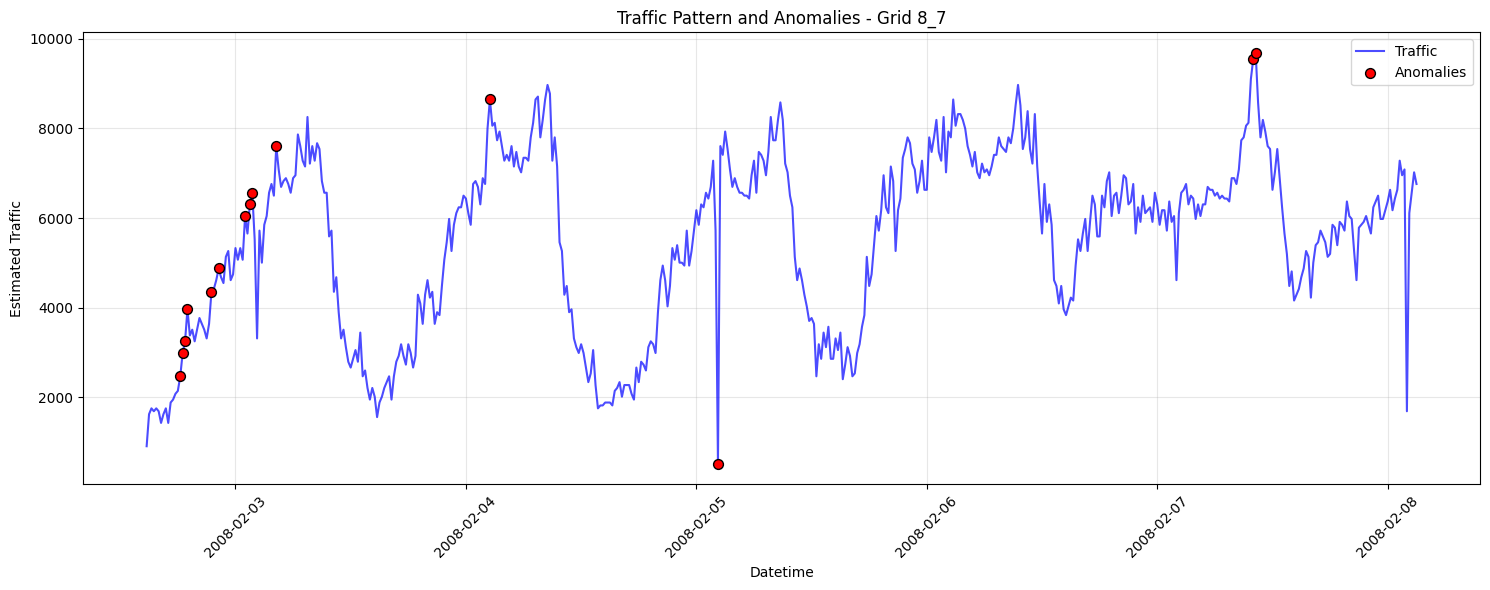

In [12]:
plot_grid_anomalies(train_data, grid_id='8_7')